In [1]:
# -*- coding: utf-8 -*-

#SIMPLER_demo, a demonstration of fluid flow solver using SIMPLER algorithm 
#Copyright (C) 2020  Boštjan Mavrič and Mihael Boštjan Končar
#
#This program is free software: you can redistribute it and/or modify
#it under the terms of the GNU General Public License as published by
#the Free Software Foundation, either version 3 of the License, or
#(at your option) any later version.
#
#This program is distributed in the hope that it will be useful,
#but WITHOUT ANY WARRANTY; without even the implied warranty of
#MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#GNU General Public License for more details.
#
#You should have received a copy of the GNU General Public License
#along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import math as mt
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg

from IPython.display import display, clear_output

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual



In [3]:
#Mapping of the indices from staggered grid to the "long" vectors used to solve systems of linear equations
def glob_ind_u(i, j, N):
    return (i) + j*(N+1)

def glob_ind_v(i, j, N):
    return (i) + j*N

def glob_ind_p(i, j, N):
    return (i) + j*N

#interpolate velocity values to the positions of pressure variables
def interpolate_to_pressure_pos(us, vs, vec, N):
    for i in range(0, N):
        for j in range(0, N):
            vec[0, i, j]=(us[i, j]+ us[i+1, j])/2
            vec[1, i, j]=(vs[i, j]+ vs[i, j+1])/2

#Map values from "long" vectors to the arrays that correspond to staggered grid.
def reshuffle_us(u_sol, us, N):
    for i in range(0, N+1):
        for j in range(0, N):
            us[i, j]=u_sol[glob_ind_u(i, j, N)]

def reshuffle_vs(v_sol, vs, N):
    for i in range(0, N):
        for j in range(0, N+1):
            vs[i, j]=v_sol[glob_ind_v(i, j, N)]

def reshuffle_p(p_sol, ps, N):
    for i in range(0, N):
        for j in range(0, N):
            ps[i, j]=p_sol[glob_ind_p(i, j, N)]


In [6]:
#Main function used to solve the system of equations
def SIMPLER_demo(N, FD_kind, Re, alpha_p, alpha_vel):
    #Nmax_iters=200
    Nmax_iters=20
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
    
    p_corr_norm=np.zeros(Nmax_iters)
    v_corr_norm=np.zeros(Nmax_iters)
    plt.ion()
    plt.show()
    
    # Storage for unknowns
    # Storage of u
    # There is one more row of u variables along x axis than along y
    Nall_u=(N)*(N+1)
    us=np.zeros([N+1, N])
    
    us_pseudo = np.zeros([N+1, N])
    ds_u_pseudo=np.zeros([N+1, N])
    
    us_old=np.zeros([N+1, N])
    ds_u=np.zeros([N+1, N])
    rhs_u=np.zeros(Nall_u)
    u_sol=np.zeros(Nall_u)

    # Storage of v
    # There is one more row of v variables along y axis than along x
    Nall_v=(N+1)*(N)
    vs=np.zeros([N, N+1])
    
    vs_pseudo = np.zeros([N, N+1])
    ds_v_pseudo=np.zeros([N, N+1])
    
    vs_old=np.zeros([N, N+1])
    ds_v=np.zeros([N, N+1])
    rhs_v=np.zeros(Nall_v)
    v_sol=np.zeros(Nall_v)

    # Storage of p
    Nall_p=(N)*(N)
    ps=np.zeros([N, N])
    vel_at_p=np.zeros([2, N, N])
    vel_norm_at_p=np.zeros([N, N])
    ps_prime=np.zeros([N, N])
    ps_step2=np.zeros([N, N])

    #To reliably solve pressure correction equation we need on more unknown for regularization of the system
    rhs_p=np.zeros(Nall_p+1)       
    p_sol=np.zeros(Nall_p+1)
    p_old=np.zeros(Nall_p+1)
    rhs_p_pseudo=np.zeros(Nall_p+1)       
    p_sol_pseudo=np.zeros(Nall_p+1)
    p_old_pseudo=np.zeros(Nall_p+1)

    #Storage for matrices
    #We use sparse matrices in "List-of-lists" for construction,before using them in the solver, they are converted to CSR format.
    sparse_u=sp.lil_matrix((Nall_u, Nall_u))
    sparse_v=sp.lil_matrix((Nall_v, Nall_v))
    sparse_p=sp.lil_matrix((Nall_p+1, Nall_p+1))
    sparse_p_pseudo=sp.lil_matrix((Nall_p+1, Nall_p+1))

    #Generation of staggered grid
    h=1./(N)

    #Points with known value of u
    points_u=np.zeros([2, Nall_u])
    for i in range(0, N+1):
        for j in range(0, N):
            Ip=glob_ind_u(i, j, N)
            points_u[0, Ip]=h*i
            points_u[1, Ip]=h/2 + h*j

    #Points with known value of v
    points_v=np.zeros([2, Nall_v])
    
    for i in range(0, N):
        for j in range(0, N+1):
            Ip=glob_ind_v(i, j, N)
            points_v[0, Ip]=h/2 + h*i
            points_v[1, Ip]=h*j
            
    #Points with known value of p        
    points_p=np.zeros([2, Nall_p])

    for i in range(0, N):
        for j in range(0, N):
            Ip=glob_ind_p(i, j, N)
            points_p[0, Ip]=h/2 + h*i
            points_p[1, Ip]=h/2 + h*j
    
    rho=1e0
    eta=1e0/Re
    v_lid=1e0

    #The expressions are simplified by assuming constant density and constant transport coefficients.
    Gamma=eta
    
    #Diffusion coefficents from V&M book
    Dw=Gamma/h
    De=Gamma/h
    Ds=Gamma/h
    Dn=Gamma/h

    A=h
#################################START OF ROUTINE ##########################################################################
    #Start the iteration loop
    for itr in range(0, Nmax_iters):
        #print(itr)
        Pe_u=0.    
        '''--------------------------PESUDO VELOCITIES -----------------------------------------'''
        # u-component of velocity, interior
        for i in range(1, N):#vrstica
            for j in range(1, N-1):#stolpec
                #Determine advective fluxes
                Fw=rho*(us[i, j] + us[i-1, j])/2
                Fe=rho*(us[i+1, j] + us[i, j])/2            
                Fs=rho*(vs[i, j] + vs[i-1, j])/2
                Fn=rho*(vs[i, j+1] + vs[i-1, j+1])/2
                #Determine the coefficents used in linear systems of equations
                if(FD_kind=="central"):
                    a_w=Dw+Fw/2
                    a_e=De-Fe/2
                    a_s=Ds+Fs/2
                    a_n=Dn-Fn/2
                elif(FD_kind=="upwind"):
                    a_w=Dw+max([Fw, 0.])
                    a_e=De+max([-Fe, 0.])
                    a_s=Ds+max([Fs, 0.])
                    a_n=Dn+max([-Fn, 0.])
                elif(FD_kind=="hybrid"):
                    a_w=max([Fw, (Dw+Fw/2), 0])
                    a_e=max([-Fe, (De-Fe/2), 0])
                    a_s=max([Fs, (Ds+Fs/2), 0])
                    a_n=max([-Fn, (Dn-Fn/2), 0])
                a_p=a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs)
                #Monitor the Peclet number
                Pe_u=max([Pe_u, max([Fw, Fe, Fs, Fn])/Dw])
                us_pseudo[i,j] = (a_w+a_e+a_s+a_n)*us[i,j]/a_p
                ds_u_pseudo[i, j]=h/a_p
                
        # u-component of velocity in cells in contact with north/south walls
        for i in range(1, N):
            for j in [0, N-1]:                               
                Fw=rho*(us[i, j] + us[i-1, j])/2
                Fe=rho*(us[i+1, j] + us[i, j])/2            
                Fs=rho*(vs[i, j] + vs[i-1, j])/2
                Fn=rho*(vs[i, j+1] + vs[i-1, j+1])/2
                if(FD_kind=="central"):
                    a_w=Dw+Fw/2
                    a_e=De-Fe/2
                    a_s=Ds+Fs/2
                    a_n=Dn-Fn/2
                elif(FD_kind=="upwind"):
                    a_w=Dw+max([Fw, 0.])
                    a_e=De+max([-Fe, 0.])
                    a_s=Ds+max([Fs, 0.])
                    a_n=Dn+max([-Fn, 0.])
                elif(FD_kind=="hybrid"):
                    a_w=max([Fw, (Dw+Fw/2), 0])
                    a_e=max([-Fe, (De-Fe/2), 0])
                    a_s=max([Fs, (Ds+Fs/2), 0])
                    a_n=max([-Fn, (Dn-Fn/2), 0])
                #Wall at y=0
                #######ali je lahko ds_u_psudo = 0??
                if(j==0):
                    a_s=0
                    a_p=a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs)
                    a_p=a_p+8*eta*h/(h/2) 
                    b_p=0
                    us_pseudo[i,j]=0
                #Wall at y=1d0, the position of moving lid.
                elif(j==N-1):
                    a_n=0
                    a_p=a_w+a_e+a_s+a_n + (Fe-Fw)+(Fn-Fs)
                    a_p=a_p+8*eta*h/(h/2)
                    b_p=8*v_lid*eta*h/(h/2)
                    #us_pseudo[i,j]=v_lid
                #ds_u[i, j]=h/a_p
                
                us_pseudo[i,j]=((a_w+a_e+a_s+a_n)*us[i,j]+b_p)/a_p
                ds_u_pseudo[i, j]=h/(a_w+a_e+a_s+a_n + (Fe-Fw)+(Fn-Fs))          
            
        # u-component of velocity in cells in contact with east/west walls
        for i in [0, N]:
            for j in range(0, N):
                #Dirichlet boundary conditions
                ds_u_pseudo[i, j]=0
                us_pseudo[i,j]=0
                
                
                
        # v-component of velocity, interior
        for i in range(1, N-1):
            for j in range(1, N):           
                Fw=rho*(us[i, j] + us[i, j-1])/2
                Fe=rho*(us[i+1, j] + us[i+1, j-1])/2
                Fs=rho*(vs[i, j-1] + vs[i, j])/2
                Fn=rho*(vs[i, j] + vs[i, j+1])/2
                if(FD_kind=="central"):
                    a_w=Dw+Fw/2
                    a_e=De-Fe/2
                    a_s=Ds+Fs/2
                    a_n=Dn-Fn/2
                elif(FD_kind=="upwind"):
                    a_w=Dw+max([Fw, 0.])
                    a_e=De+max([-Fe, 0.])
                    a_s=Ds+max([Fs, 0.])
                    a_n=Dn+max([-Fn, 0.])
                elif(FD_kind=="hybrid"):
                    a_w=max([Fw, (Dw+Fw/2), 0.])
                    a_e=max([-Fe, (De-Fe/2), 0.])
                    a_s=max([Fs, (Ds+Fs/2), 0.])
                    a_n=max([-Fn, (Dn-Fn/2), 0.])
                a_p=a_w+a_e+a_s+a_n +(Fe-Fw) +(Fn-Fs)
                vs_pseudo[i,j] = (a_w+a_e+a_s+a_n)*vs[i,j]/a_p
                ds_v_pseudo[i, j]=h/a_p

        # v-component of velocity in cells in contact with east/west walls
        for i in [0, N-1]:
            for j in range(1, N):           
                Fw=rho*(us[i, j] + us[i-1, j])/2
                Fe=rho*(us[i+1, j] + us[i, j])/2            
                Fs=rho*(vs[i, j] + vs[i-1, j])/2
                Fn=rho*(vs[i, j+1] + vs[i-1, j+1])/2
                if(FD_kind=="central"):
                    a_w=Dw+Fw/2
                    a_e=De-Fe/2
                    a_s=Ds+Fs/2
                    a_n=Dn-Fn/2
                elif(FD_kind=="upwind"):
                    a_w=Dw+max([Fw, 0.])
                    a_e=De+max([-Fe, 0.])
                    a_s=Ds+max([Fs, 0.])
                    a_n=Dn+max([-Fn, 0.])
                    
                elif(FD_kind=="hybrid"):
                    a_w=max([Fw, (Dw+Fw/2), 0])
                    a_e=max([-Fe, (De-Fe/2), 0])
                    a_s=max([Fs, (Ds+Fs/2), 0])
                    a_n=max([-Fn, (Dn-Fn/2), 0])            
                if(i==0):
                    a_w=0
                    a_p=a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs)
                    a_p=a_p+8*eta*h/(h/2)
                elif(i==N-1):
                    a_e=0
                    a_p=a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs)
                    a_p=a_p+8*eta*h/(h/2)
                #ds_v[i, j]=h/a_p
                
                b_p=0
                vs_pseudo[i,j] =((a_w+a_e+a_s+a_n)*vs[i,j]+b_p) /a_p
                ds_v_pseudo[i, j]=h/(a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs))

        # v-component of velocity in cells in contact with north/south walls
        for i in range(0, N):
            for j in [0, N]:
                vs_pseudo[i,j]=0
                ds_v_pseudo[i, j]=0
                
        '''set new guess velocities'''
        print('us_pseudo\n',us_pseudo,'\nvs_pseudo\n',vs_pseudo)
        us=us_pseudo
        vs=vs_pseudo
        




                
                
                
                
            
            
####################################################################################
    #Assemble the pressure matrix
        for i in range(0, N):
            for j in range(0, N):
                Ip=glob_ind_p(i, j, N)
                Ie=glob_ind_p(i+1, j, N)
                Iw=glob_ind_p(i-1, j, N)
                In=glob_ind_p(i, j+1, N)
                Is=glob_ind_p(i, j-1, N)

                a_e=ds_u_pseudo[i+1, j]/h
                a_w=ds_u_pseudo[i, j]/h
                a_n=ds_v_pseudo[i, j+1]/h
                a_s=ds_v_pseudo[i, j]/h

                #Treat the boundary conditions
                if(i==0) :
                    #a_w=0
                    a_w=2*a_w
                else:
                    sparse_p_pseudo[Ip, Iw]=-a_w
                    
                if(i==N-1):
                    #a_e=0
                    a_e=2*a_e
                else:
                    sparse_p_pseudo[Ip, Ie]=-a_e
                
                if(j==0):
                    #a_s=0
                    a_s=2*a_s
                else:
                    sparse_p_pseudo[Ip, Is]=-a_s
                
                if(j==N-1):
                    #a_n=0
                    a_n=2*a_n
                else:
                    sparse_p_pseudo[Ip, In]=-a_n
                
                a_p=a_e+a_w+a_n+a_s
                sparse_p_pseudo[Ip, Ip]=a_p
            
                rhs_p_pseudo[Ip]=h*(us_pseudo[i,j] - us_pseudo[i+1,j] + vs_pseudo[i,j] - vs_pseudo[i,j+1])   

        #Add the regularization equation sum(p)=0
        rhs_p_pseudo[Nall_p]=0
        sparse_p_pseudo[0:Nall_p, Nall_p]=1e0
        sparse_p_pseudo[Nall_p, 0:Nall_p]=1e0

        #Solve the system of equations
        p_old_pseudo=p_sol_pseudo.copy()
        p_sol_pseudo=sp_linalg.spsolve(sparse_p_pseudo.tocsr(), rhs_p_pseudo)
        p_vals_pseudo=p_sol_pseudo[0:Nall_p]
        #print("Pe_u:", Pe_u)
        reshuffle_p(p_sol_pseudo, ps_step2, N)
        
        #print('ps',ps_step2)
        #set p*=p
        ps = ps_step2
        #s1=sparse_p
        #print('s1',s1)
        print('ps_pseud\n',ps)
    
    

    
########################################## Simpler step 3 #####################################################
        # u-component of velocity, interior
        for i in range(1, N):
            for j in range(1, N-1):
                #Determine indices of points under consideration
                Ip=glob_ind_u(i, j, N)
                Ie=glob_ind_u(i+1, j, N)
                Iw=glob_ind_u(i-1, j, N)
                In=glob_ind_u(i, j+1, N)
                Is=glob_ind_u(i, j-1, N)

                #Determine advective fluxes
                Fw=rho*(us[i, j] + us[i-1, j])/2
                Fe=rho*(us[i+1, j] + us[i, j])/2
            
                Fs=rho*(vs[i, j] + vs[i-1, j])/2
                Fn=rho*(vs[i, j+1] + vs[i-1, j+1])/2

                #Determine the coefficents used in linear systems of equations
                if(FD_kind=="central"):
                    a_w=Dw+Fw/2
                    a_e=De-Fe/2
                    a_s=Ds+Fs/2
                    a_n=Dn-Fn/2
                elif(FD_kind=="upwind"):
                    a_w=Dw+max([Fw, 0.])
                    a_e=De+max([-Fe, 0.])
                    a_s=Ds+max([Fs, 0.])
                    a_n=Dn+max([-Fn, 0.])
                elif(FD_kind=="hybrid"):
                    a_w=max([Fw, (Dw+Fw/2), 0])
                    a_e=max([-Fe, (De-Fe/2), 0])
                    a_s=max([Fs, (Ds+Fs/2), 0])
                    a_n=max([-Fn, (Dn-Fn/2), 0])

                a_p=a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs)

                #Monitor the Peclet number
                Pe_u=max([Pe_u, max([Fw, Fe, Fs, Fn])/Dw])
                
                #Populate the matrix elements
                sparse_u[Ip, In]=-a_n
                sparse_u[Ip, Iw]=-a_w
                sparse_u[Ip, Ip]=a_p
                sparse_u[Ip, Ie]=-a_e
                sparse_u[Ip, Is]=-a_s

                #Store for pressure correction
                ds_u[i, j]=h/a_p
            
                #Set up RHS for u-component
                rhs_u[Ip]=A*(ps[i-1, j] - ps[i, j])

        # u-component of velocity in cells in contact with north/south walls
        for i in range(1, N):
            for j in [0, N-1]:
                
                Ip=glob_ind_u(i, j, N)
                Ie=glob_ind_u(i+1, j, N)
                Iw=glob_ind_u(i-1, j, N)
                In=glob_ind_u(i, j+1, N)
                Is=glob_ind_u(i, j-1, N)
                
                Fw=rho*(us[i, j] + us[i-1, j])/2
                Fe=rho*(us[i+1, j] + us[i, j])/2
            
                Fs=rho*(vs[i, j] + vs[i-1, j])/2
                Fn=rho*(vs[i, j+1] + vs[i-1, j+1])/2

                if(FD_kind=="central"):
                    a_w=Dw+Fw/2
                    a_e=De-Fe/2
                    a_s=Ds+Fs/2
                    a_n=Dn-Fn/2
                elif(FD_kind=="upwind"):
                    a_w=Dw+max([Fw, 0.])
                    a_e=De+max([-Fe, 0.])
                    a_s=Ds+max([Fs, 0.])
                    a_n=Dn+max([-Fn, 0.])
                elif(FD_kind=="hybrid"):
                    a_w=max([Fw, (Dw+Fw/2), 0])
                    a_e=max([-Fe, (De-Fe/2), 0])
                    a_s=max([Fs, (Ds+Fs/2), 0])
                    a_n=max([-Fn, (Dn-Fn/2), 0])

                sparse_u[Ip, Iw]=-a_w
                sparse_u[Ip, Ie]=-a_e

                #Wall at y=0
                if(j==0):
                    a_s=0
                    a_p=a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs)
                    a_p=a_p+8*eta*h/(h/2)
                    sparse_u[Ip, Ip]=a_p
                    sparse_u[Ip, In]=-a_n

                    #Set up RHS for u-component
                    rhs_u[Ip]=A*(ps[i-1, j] - ps[i, j])
                    
                #Wall at y=1d0, the position of moving lid.
                elif(j==N-1):
                    a_n=0
                    a_p=a_w+a_e+a_s+a_n + (Fe-Fw)+(Fn-Fs)
                    a_p=a_p+8*eta*h/(h/2)
                    sparse_u[Ip, Ip]=a_p
                    sparse_u[Ip, Is]=-a_s

                    #Set up RHS for u-component, the last term provides the driving
                    rhs_u[Ip]=A*(ps[i-1, j] - ps[i, j]) + 8*v_lid*eta*h/(h/2)
                
                #ds_u[i, j]=h/a_p          
                ds_u[i, j]=h/(a_w+a_e+a_s+a_n + (Fe-Fw)+(Fn-Fs))          
            
        # u-component of velocity in cells in contact with east/west walls
        for i in [0, N]:
            for j in range(0, N):
                #print("Normal - u:", (i, j))
                Ip=glob_ind_u(i, j, N)

                #Dirichlet boundary conditions
                sparse_u[Ip, Ip]=1
            
                ds_u[i, j]=0
            
                #Set up RHS for u-component
                rhs_u[Ip]=0

        #The same procedure for v component
        ###################################
        # v-component of velocity, interior
        for i in range(1, N-1):
            for j in range(1, N):
                
                Ip=glob_ind_v(i, j, N)
                Ie=glob_ind_v(i+1, j, N)
                Iw=glob_ind_v(i-1, j, N)
                In=glob_ind_v(i, j+1, N)
                Is=glob_ind_v(i, j-1, N)
            
                Fw=rho*(us[i, j] + us[i, j-1])/2
                Fe=rho*(us[i+1, j] + us[i+1, j-1])/2
            
                Fs=rho*(vs[i, j-1] + vs[i, j])/2
                Fn=rho*(vs[i, j] + vs[i, j+1])/2

                if(FD_kind=="central"):
                    a_w=Dw+Fw/2
                    a_e=De-Fe/2
                    a_s=Ds+Fs/2
                    a_n=Dn-Fn/2
                elif(FD_kind=="upwind"):
                    a_w=Dw+max([Fw, 0.])
                    a_e=De+max([-Fe, 0.])
                    a_s=Ds+max([Fs, 0.])
                    a_n=Dn+max([-Fn, 0.])
                elif(FD_kind=="hybrid"):
                    a_w=max([Fw, (Dw+Fw/2), 0.])
                    a_e=max([-Fe, (De-Fe/2), 0.])
                    a_s=max([Fs, (Ds+Fs/2), 0.])
                    a_n=max([-Fn, (Dn-Fn/2), 0.])
                
                a_p=a_w+a_e+a_s+a_n +(Fe-Fw) +(Fn-Fs)

                sparse_v[Ip, In]=-a_n
                sparse_v[Ip, Iw]=-a_w
                sparse_v[Ip, Ip]=a_p
                sparse_v[Ip, Ie]=-a_e
                sparse_v[Ip, Is]=-a_s

                ds_v[i, j]=h/a_p
            
                #Set up RHS for v-component
                rhs_v[Ip]=A*(ps[i, j-1] - ps[i, j])

        # v-component of velocity in cells in contact with east/west walls
        for i in [0, N-1]:
            for j in range(1, N):
                #print("Tangential - v:", (i, j))
            
                Ip=glob_ind_v(i, j, N)
                Ie=glob_ind_v(i+1, j, N)
                Iw=glob_ind_v(i-1, j, N)
                In=glob_ind_v(i, j+1, N)
                Is=glob_ind_v(i, j-1, N)
            
                Fw=rho*(us[i, j] + us[i-1, j])/2
                Fe=rho*(us[i+1, j] + us[i, j])/2
            
                Fs=rho*(vs[i, j] + vs[i-1, j])/2
                Fn=rho*(vs[i, j+1] + vs[i-1, j+1])/2

                if(FD_kind=="central"):
                    a_w=Dw+Fw/2
                    a_e=De-Fe/2
                    a_s=Ds+Fs/2
                    a_n=Dn-Fn/2
                elif(FD_kind=="upwind"):
                    a_w=Dw+max([Fw, 0.])
                    a_e=De+max([-Fe, 0.])
                    a_s=Ds+max([Fs, 0.])
                    a_n=Dn+max([-Fn, 0.])
                elif(FD_kind=="hybrid"):
                    a_w=max([Fw, (Dw+Fw/2), 0])
                    a_e=max([-Fe, (De-Fe/2), 0])
                    a_s=max([Fs, (Ds+Fs/2), 0])
                    a_n=max([-Fn, (Dn-Fn/2), 0])

                sparse_v[Ip, In]=-a_n
                sparse_v[Ip, Is]=-a_s
            
                if(i==0):
                    a_w=0
                    a_p=a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs)
                    a_p=a_p+8*eta*h/(h/2)
                    sparse_v[Ip, Ip]=a_p
                    sparse_v[Ip, Ie]=-a_e
                elif(i==N-1):
                    a_e=0
                    a_p=a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs)
                    a_p=a_p+8*eta*h/(h/2)
                    sparse_v[Ip, Ip]=a_p
                    sparse_v[Ip, Iw]=-a_w
                
                #ds_v[i, j]=h/a_p
                ds_v[i, j]=h/(a_w+a_e+a_s+a_n +(Fe-Fw)+(Fn-Fs))
            
                #Set up RHS for v-component
                rhs_v[Ip]=A*(ps[i, j-1] - ps[i, j])

        # v-component of velocity in cells in contact with north/south walls
        for i in range(0, N):
            for j in [0, N]:

                Ip=glob_ind_v(i, j, N)
            
                sparse_v[Ip, Ip]=1
            
                ds_v[i, j]=0
            
                #Set up RHS for u-component
                rhs_v[Ip]=0

        #Solve the system of equations for u
        u_sol=sp_linalg.spsolve(sparse_u.tocsr(), rhs_u)
        reshuffle_us(u_sol, us, N)

        # Solve the system of equations for v
        v_sol=sp_linalg.spsolve(sparse_v.tocsr(), rhs_v)
        reshuffle_vs(v_sol, vs, N)
        
        
        #Assemble the pressure matrix
        for i in range(0, N):
            for j in range(0, N):
                Ip=glob_ind_p(i, j, N)
                Ie=glob_ind_p(i+1, j, N)
                Iw=glob_ind_p(i-1, j, N)
                In=glob_ind_p(i, j+1, N)
                Is=glob_ind_p(i, j-1, N)

                a_e=ds_u[i+1, j]/h
                a_w=ds_u[i, j]/h
                a_n=ds_v[i, j+1]/h
                a_s=ds_v[i, j]/h

                #Treat the boundary conditions
                if(i==0) :
                    #a_w=0
                    a_w=2*a_w
                else:
                    sparse_p[Ip, Iw]=-a_w
                    
                if(i==N-1):
                    #a_e=0
                    a_e=2*a_e
                else:
                    sparse_p[Ip, Ie]=-a_e
                
                if(j==0):
                    #a_s=0
                    a_s=2*a_s
                else:
                    sparse_p[Ip, Is]=-a_s
                
                if(j==N-1):
                    #a_n=0
                    a_n=2*a_n
                else:
                    sparse_p[Ip, In]=-a_n
                
                a_p=a_e+a_w+a_n+a_s
                sparse_p[Ip, Ip]=a_p
            
                rhs_p[Ip]=h*(us[i,j] - us[i+1,j] + vs[i,j] - vs[i,j+1])   

        #Add the regularization equation sum(p)=0
        rhs_p[Nall_p]=0
        sparse_p[0:Nall_p, Nall_p]=1e0
        sparse_p[Nall_p, 0:Nall_p]=1e0

        #Solve the system of equations
        p_old=p_sol.copy()
        p_sol=sp_linalg.spsolve(sparse_p.tocsr(), rhs_p)
        p_vals=p_sol[0:Nall_p]
        #print("Pe_u:", Pe_u)
        reshuffle_p(p_sol, ps_prime, N)
        p_corr_norm[itr]=np.linalg.norm(ps_prime)/(np.linalg.norm(ps))
        #print("Pressure corr:", p_corr_norm[itr])
        #alpha_p=0.9e0
        #alpha_vel=0.95e0
        print('ps_prime\n',ps_prime)
        #Update pressure
        ps=ps+alpha_p*ps_prime
        
        #correct u values
        for i in range(1, N):
            for j in range(0, N):
                us[i, j]=us[i, j] + ds_u[i, j]*(ps_prime[i-1, j]-ps_prime[i, j])

        #print(us_old)
        #print(us)
        v_corr_norm[itr]=np.linalg.norm(us-us_old)/(np.linalg.norm(us_old))
        #print("u update:",v_corr_norm[itr])
        #print("u max:", np.amax(us_old))
        #print("v max:", np.amax(vs_old))
        
        #correct v values
        for i in range(0, N):
            for j in range(1, N):
                vs[i, j]=vs[i, j] + ds_v[i, j]*(ps_prime[i, j-1]-ps_prime[i, j])

        #Under-relax velocity corrections
        us=alpha_vel*us + (1.-alpha_vel)*us_old
        us_old=us.copy()
        print('us\n',us)
        
        vs=alpha_vel*vs + (1.-alpha_vel)*vs_old
        vs_old=vs.copy()
        print('vs\n',us)

        #Extract data for plotting
        interpolate_to_pressure_pos(us, vs, vel_at_p, N)
        for i in range(0, N):
            for j in range(0, N):
                vel_norm_at_p[i, j]=np.linalg.norm(vel_at_p[:, i, j])

        #plt.clf()
        pmin=np.amin(ps)
        pmax=np.amax(ps)

        ax1.cla()
        ax2.cla()
        ax3.cla()
        #fig.clf()
        ax1.set_title("Streamlines and pressure field")
        ax1.contourf(ps.transpose(), levels=np.linspace(pmin, pmax, 30), cmap='YlGnBu_r')
        ax1.streamplot(points_p[0, 0:N]*N, points_p[1, 0:Nall_p:N]*N, vel_at_p[0, :, :].transpose(), vel_at_p[1, :, :].transpose(), color=vel_norm_at_p.transpose(), density=1, linewidth=3., cmap='hot')

        ax1.set_aspect('equal')
        
        ax2.set_title("Relative magnitude of corrections")
        ax2.set_yscale('log')
        press_line=ax2.plot(p_corr_norm[1:itr], label="Pressure")
        vel_line=ax2.plot(v_corr_norm[1:itr], label="Velocity")
        ax2.legend()
        
        ax3.plot(vs[:, int(N/2)+1], label="v @ y=0.5")
        ax3.plot(us[int(N/2)+1, :], label="u @ x=0.5")
        ax3.set_title("Velocity profiles")
        ax3.legend()
        #plt.draw()
        clear_output(wait=True)
        display(fig)
        #plt.show()
        #plt.pause(.0001)
        
        
    plt.ioff()    
    plt.clf()
    plt.title("Final velocity")
    plt.axes().set_aspect('equal')
    plt.streamplot(points_p[0, 0:N], points_p[1, 0:Nall_p:N], vel_at_p[0, :, :].transpose(), vel_at_p[1, :, :].transpose(), color=vel_norm_at_p.transpose(), density=3)
    plt.show()
    
    pmin=np.amin(ps)
    pmax=np.amax(ps)
    
    plt.clf()
    plt.title("Final pressure")
    plt.axes().set_aspect('equal')
    plt.contourf(ps.transpose(), levels=np.linspace(pmin, pmax, 20))
    plt.show()  



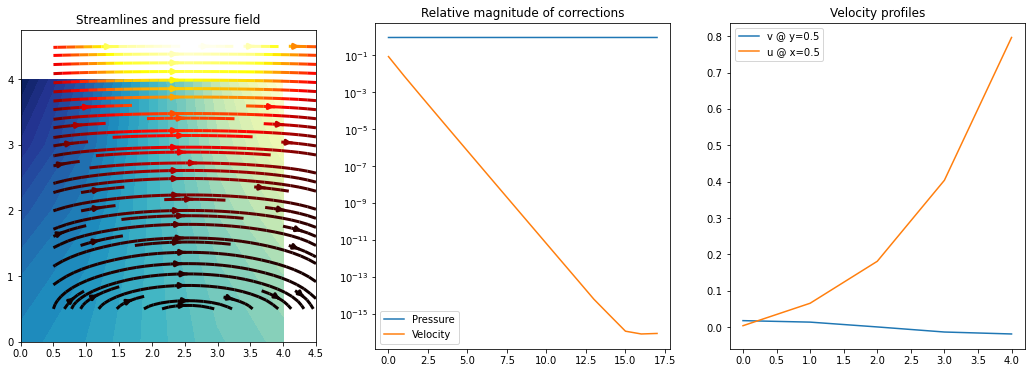

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:723: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


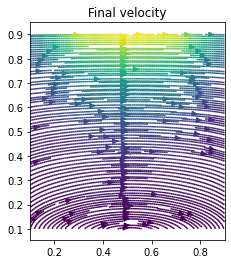

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:732: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


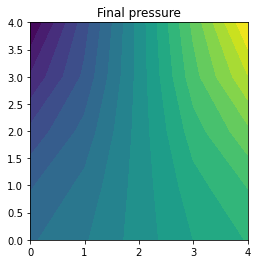

In [7]:
SIMPLER_demo(N=5, FD_kind='central', Re=1, alpha_p=0.9, alpha_vel=0.9)